<a href="https://colab.research.google.com/github/absbin/Video-Processing-Library-MATLAB/blob/master/Deep_Features_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
from tqdm import tqdm

import os
import sys
import cv2
import glob
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn import svm
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

use_gpu = torch.cuda.is_available()

In [3]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()


Saving data_utils.py to data_utils.py
Saving train.py to train.py
Saving utils.py to utils.py
Saving vis_utils.py to vis_utils.py


In [4]:
!pip install bcolz
from utils import to_var
from train import train_model
from data_utils import create_validation_data
from vis_utils import imshow

    100% |████████████████████████████████| 1.5MB 14.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-02-04 19:57:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   100MB/s    in 0.7s    

2019-02-04 19:57:11 (100 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')




sz = 299  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 2

In [7]:
os.listdir(base_dir)

['train', 'validation', 'vectorize.py']

In [0]:
trn_dir = train_dir
val_dir = validation_dir

In [9]:
trn_frames = glob.glob(f'{trn_dir}/*/*.jpg')
val_frames = glob.glob(f'{val_dir}/*/*.jpg')
len(val_frames)


1000

In [0]:
frames = glob.glob(f'{trn_dir}/cats/*.jpg')

**Model**

In [0]:
def get_model(model_name, num_classes, pretrained=True):
    return models.__dict__[model_name](pretrained)


In [0]:


class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes
        
        # create cnn model
        model = get_model(model_name, num_classes)
        
        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes) # classifier + localizer
        self.model = model
    
    def forward(self, x):
        x = self.model(x)                    # extract features from CNN

        return x     # sigmoid output is in [0, 1]


In [13]:
model = ClassifierLocalizer(model_name)
if use_gpu: model = model.cuda()
    

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 47595238.42it/s]


In [0]:
model = ClassifierLocalizer(model_name)
if use_gpu: model = model.cuda()
    

In [0]:
trn_frames = glob.glob(f'{train_dir}/*/*.jpg')

In [16]:
os.listdir(train_dir)


['dogs', 'cats']

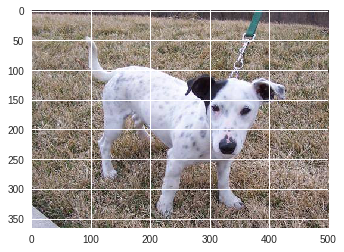

In [17]:
img=plt.imread(trn_frames[55])
plt.imshow(img)

In [0]:
from keras.preprocessing import image
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
def feature_extractor(X):

    trn_dir=X
    #model_vgg16 = VGG16(weights='imagenet', include_top=False)
    model_vgg16 = ResNet50(weights='imagenet', include_top=False)
    vgg16_feature_list = []
    vgg16_feature_list_np=[]
    labels_true=[]
    labels_pred=[]
    for idx, dirname in enumerate(os.listdir(trn_dir)):
        # get the directory names, i.e., 'dogs' or 'cats'
        # ...

        print(idx,dirname)
        class_frames=glob.glob(f'{os.path.join(trn_dir, dirname)}/*.jpg')
        for i, fname in enumerate(class_frames ):

            print(i,fname)
            # process the files under the directory 'dogs' or 'cats'
            # ...       
            img = image.load_img(fname, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)

            vgg16_feature = model_vgg16.predict(img_data)
            vgg16_feature_np = np.array(vgg16_feature)
            vgg16_feature_list.append(vgg16_feature_np.flatten())
            labels_true.append(idx)
    vgg16_feature_list_np = np.array(vgg16_feature_list)
    labels_true = np.array(labels_true)
    return vgg16_feature_list_np , labels_true


In [24]:
x_train,y_train=feature_extractor(trn_dir)
x_valid,y_valid=feature_extractor(val_dir)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


0 dogs
0 /tmp/cats_and_dogs_filtered/train/dogs/dog.25.jpg
1 /tmp/cats_and_dogs_filtered/train/dogs/dog.584.jpg
2 /tmp/cats_and_dogs_filtered/train/dogs/dog.90.jpg
3 /tmp/cats_and_dogs_filtered/train/dogs/dog.514.jpg
4 /tmp/cats_and_dogs_filtered/train/dogs/dog.751.jpg
5 /tmp/cats_and_dogs_filtered/train/dogs/dog.397.jpg
6 /tmp/cats_and_dogs_filtered/train/dogs/dog.931.jpg
7 /tmp/cats_and_dogs_filtered/train/dogs/dog.650.jpg
8 /tmp/cats_and_dogs_filtered/train/dogs/dog.952.jpg
9 /tmp/cats_and_dogs_filtered/train/dogs/dog.203.jpg
10 /tmp/cats_and_dogs_filtered/train/dogs/dog.833.jpg
11 /tmp/cats_and_dogs_filtered/train/dogs/dog.30.jpg
12 /tmp/cats_and_dogs_filtered/train/dogs/dog.876.jpg
13 /tmp/cats_and_dogs_filtered/train/dogs/dog.178.jpg
14 /tmp/cats_and_dogs_filtered/train/dogs/dog.863.jpg
15 /tmp/cats_and_dogs_filtered/train/dogs/dog.142.jpg
16 /tmp/cats_and_dogs_filtered/train/dogs/dog.826.jpg
17 /tmp/cats_and_dogs_filtered/train/dogs/dog.763.jpg
18 /tmp/cats_and_dogs_filtered/tra

In [25]:
(x_train.shape,x_valid.shape)

((2000, 100352), (1000, 100352))

In [26]:
(np.sort(x_train[1]),np.sort(x_valid[900]))

(array([ 0.      ,  0.      ,  0.      , ..., 32.322197, 35.222023,
        36.24603 ], dtype=float32),
 array([ 0.      ,  0.      ,  0.      , ..., 44.088257, 46.20623 ,
        46.932762], dtype=float32))

In [33]:

kmeans_model = KMeans(n_clusters=2, random_state=1).fit(x_train)
y_train_pred = kmeans_model.labels_
metrics.accuracy_score(y_train, y_train_pred)

0.0365

# **CLASSIFIER 


**SVM**

In [28]:


clf = svm.SVC(gamma='scale')
clf.fit(x_train, y_train)  


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
clf.score(x_valid, y_valid, sample_weight=None)

0.99

In [30]:
y_valid_pred=clf.predict(x_valid)
print(confusion_matrix(y_valid,y_valid_pred))

[[498   2]
 [  8 492]]


In [31]:

y_valid_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## ***Random Forest***

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
X =x_train
Y = y_train
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)
scores = cross_val_score(clf, x_valid, y_valid, cv=5)
scores.mean() 


0.95

In [36]:
y_valid_pred=clf.predict(x_valid)
print(confusion_matrix(y_valid,y_valid_pred))

[[488  12]
 [ 33 467]]
